In [4]:
from IPython.parallel import Client
c = Client()
print(c.ids)
c[:].apply_sync(lambda : "Hello, World")

[0, 1, 2, 3]


['Hello, World', 'Hello, World', 'Hello, World', 'Hello, World']

In [5]:
lview = c.load_balanced_view()
lview.block = True
serial_result = map(lambda x:x**10, range(32))
parallel_result = lview.map(lambda x:x**10, range(32))
serial_result==parallel_result

False

In [64]:
view.run('psum.py')

<AsyncResult: finished>

In [67]:
view.apply(psum

NameError: name 'psum' is not defined

In [26]:
view['a']

CompositeError: one or more exceptions from call to method: _pull
[0:apply]: NameError: name 'a' is not defined
[1:apply]: NameError: name 'a' is not defined
[2:apply]: NameError: name 'a' is not defined
[3:apply]: NameError: name 'a' is not defined

In [27]:
view.scatter('a', np.arange(100, dtype='float'))

NameError: name 'np' is not defined

In [7]:
import platform
from pprint import pprint as pp
print('Machine:',platform.machine())
print('Platform Version:',platform.version())
print('Platform:',platform.platform())
pp(platform.uname())
print('System:',platform.system())
print('Processor:',platform.processor())

Machine: x86_64
Platform Version: #1 SMP Tue Nov 18 14:25:50 CET 2014
Platform: Linux-2.6.32-504.1.3.el6.euler.x86_64-x86_64-with-centos-6.6-Final
uname_result(system='Linux', node='euler04', release='2.6.32-504.1.3.el6.euler.x86_64', version='#1 SMP Tue Nov 18 14:25:50 CET 2014', machine='x86_64', processor='x86_64')
System: Linux
Processor: x86_64


In [8]:
import os
import sys
import string

def lin_com(b):
    h = os.popen(b)
    k = h.readlines()
    #k = k[:len(k)-1]
    h.close()
    return k


g =  lin_com("cat /proc/cpuinfo")
#g = g[6]
#g = g.split(':')[1:]

pp(g)

['processor\t: 0\n',
 'vendor_id\t: GenuineIntel\n',
 'cpu family\t: 6\n',
 'model\t\t: 62\n',
 'model name\t: Intel(R) Xeon(R) CPU E5-2697 v2 @ 2.70GHz\n',
 'stepping\t: 4\n',
 'microcode\t: 1064\n',
 'cpu MHz\t\t: 2700.000\n',
 'cache size\t: 30720 KB\n',
 'physical id\t: 0\n',
 'siblings\t: 1\n',
 'core id\t\t: 0\n',
 'cpu cores\t: 1\n',
 'apicid\t\t: 0\n',
 'initial apicid\t: 0\n',
 'fpu\t\t: yes\n',
 'fpu_exception\t: yes\n',
 'cpuid level\t: 13\n',
 'wp\t\t: yes\n',
 'flags\t\t: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov '
 'pat pse36 clflush dts mmx fxsr sse sse2 ss syscall nx rdtscp lm '
 'constant_tsc arch_perfmon pebs bts xtopology tsc_reliable nonstop_tsc '
 'aperfmperf unfair_spinlock pni pclmulqdq ssse3 cx16 pcid sse4_1 sse4_2 '
 'x2apic popcnt aes xsave avx f16c rdrand hypervisor lahf_lm ida arat epb '
 'pln pts dts fsgsbase smep\n',
 'bogomips\t: 5400.00\n',
 'clflush size\t: 64\n',
 'cache_alignment\t: 64\n',
 'address sizes\t: 40 bits physical, 48 bi

In [40]:
%pylab inline
import time
import numpy as np

from IPython.display import Image

from IPython import parallel

# rc = parallel.Client()
rc = parallel.Client(packer='pickle')
view = rc.load_balanced_view()

Populating the interactive namespace from numpy and matplotlib


In [41]:
print(rc.ids)

[0, 1, 2, 3]


In [46]:
def test_latency(v, n):
    tic = time.time()
    echo = lambda x: x
    tic = time.time()
    for i in range(n):
        v.apply_async(echo, '')
    toc = time.time()
    v.wait()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [47]:
sends = []
roundtrips = []
ns = [1,4,8,16,32,64,128,256,512,1024,2048,4096]
for n in ns:
    # short rest between tests
    time.sleep(1)
    s,rt = test_latency(view, n)
    s = n/s
    rt = n/rt
    sends.append(s)
    roundtrips.append(rt)
    print("%4i %6.1f %6.1f" % (n,s,rt))

   1 1256.9  118.7
   4 2002.1  351.6
   8 2127.6  407.9
  16 1930.0  474.4
  32 1773.6  487.1
  64 2032.1  500.0
 128 1720.4  545.6
 256 1885.2  519.4
 512 1981.7  508.9
1024 2152.8  531.2
2048 1890.3  518.2
4096 1603.2  520.7


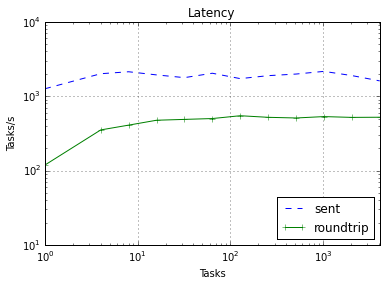

In [48]:
plt.title("Latency")
# ns, sends, roundtrips = map(np.array, [ns, sends, roundtrips])
plt.loglog(ns, sends, '--', label='sent')
plt.loglog(ns, roundtrips, '-+', label='roundtrip')
plt.legend(loc="lower right")
plt.xlabel("Tasks")
plt.ylabel("Tasks/s")
plt.ylim(1e1,1e4)
plt.xlim(ns[0], ns[-1])
plt.grid(True)

In [51]:
def test_throughput(v, n, s):
    A = np.random.random(s/8) # doubles are 8B
    tic = time.time()
    echo = lambda x: x
    tic = time.time()
    for i in range(n):
        v.apply_async(echo, A)
    toc = time.time()
    v.wait()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [52]:
n = 128
sizes = np.logspace(7,20,14, base=2)
t_sends = []
t_roundtrips = []
for sz in sizes:
    # short rest between tests
    time.sleep(1)
    s,rt = test_throughput(view, n, int(sz))
    s = n/s
    rt = n/rt
    t_sends.append(s)
    t_roundtrips.append(rt)
    print("%8i  %6.1f  %6.1f" % (sz,s,rt))

     128  1843.5   525.6
     256  1943.4   508.9
     512  1680.1   508.9
    1024  1772.3   512.0
    2048  2039.4   528.3
    4096  2007.2   527.3
    8192  2142.4   506.7
   16384  1686.2   501.8
   32768  1583.5   494.7
   65536  1910.0   464.7
  131072  1727.8   468.4
  262144  1411.9   451.5
  524288   792.0   333.3
 1048576  1081.4   246.8


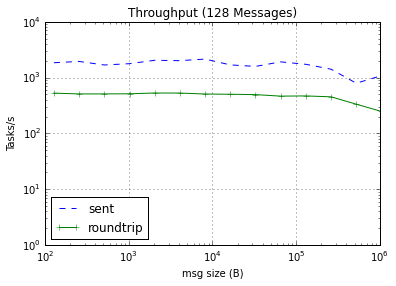

In [53]:
plt.title("Throughput (%i Messages)" % n)
plt.xlabel("msg size (B)")
plt.ylabel("Tasks/s")
plt.loglog(sizes, t_sends, '--', label='sent')
plt.loglog(sizes, t_roundtrips, '-+', label='roundtrip')
plt.ylim(1,1e4)
plt.xlim(1e2,1e6)
plt.legend(loc="lower left")
plt.grid(True)

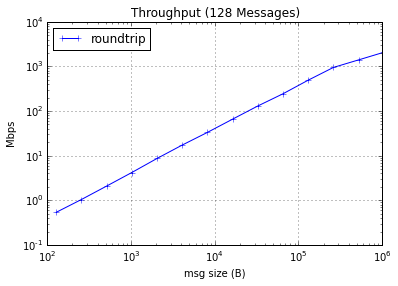

In [54]:
plt.title("Throughput (%i Messages)" % n)
plt.xlabel("msg size (B)")
plt.ylabel("Mbps")
sizes, t_sends, t_roundtrips = map(np.array, [sizes, t_sends, t_roundtrips])
plt.loglog(sizes, 8e-6*sizes*t_roundtrips, '-+', label='roundtrip')
# plt.ylim(1,1e4)
plt.xlim(1e2,1e6)
plt.legend(loc="upper left")
plt.grid(True)

In [56]:
def test_map(v,dt,n):
    ts = [dt]*n
    tic = time.time()
    amr = v.map_async(time.sleep, ts)
    toc = time.time()
    amr.get()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [57]:
n = len(rc.ids) * 16
for dt in np.logspace(-3,0,7):
    time.sleep(0.5)
    s,rt = test_map(view, dt, n)
    print("%4ims %5.1f%%" % (1000*dt, 1600*dt / rt))

   1ms  11.7%
   3ms  35.5%
  10ms  65.5%
  31ms  85.8%
 100ms  95.2%
 316ms  98.2%
1000ms  99.4%
